In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import itertools
import ast

In [2]:
""" MusicOSet """

fp = "../data/musicoset_metadata/songs.csv"
df_songs_meta = pd.read_csv(fp, sep='\t')
print("SONGS")
print(df_songs_meta.head())

fp = "../data/musicoset_metadata/artists.csv"
df_artists_meta = pd.read_csv(fp, sep='\t')
print("\n---------------------\n")
print("ARTISTS")
print(df_artists_meta.head())

fp = "../data/musicoset_metadata/tracks.csv"
df_tracks_meta = pd.read_csv(fp, sep='\t')
print("\n---------------------\n")
print("TRACKS")
print(df_tracks_meta.head())

fp = "../data/musicoset_songfeatures/lyrics.csv"
df_lyrics = pd.read_csv(fp, sep='\t')
print("\n---------------------\n")
print("LYRICS")
print(df_lyrics.head())

fp = "../data/musicoset_songfeatures/acoustic_features.csv"
df_acoustic_features = pd.read_csv(fp, sep='\t')
print("\n---------------------\n")
print("ACOUSTIC FEATURES")
print(df_acoustic_features.head())


SONGS
                  song_id                                      song_name  \
0  3e9HZxeyfWwjeyPAMmWSSQ                                  thank u, next   
1  5p7ujcrUXASCNwRaWNHR1C                                     Without Me   
2  2xLMifQCjDGFmkHkpNLD9h                                     SICKO MODE   
3  3KkXRkHbMCARz0aVfEt68P  Sunflower - Spider-Man: Into the Spider-Verse   
4  1rqqCSm0Qe4I9rUvWncaom                                     High Hopes   

                                           billboard  \
0                 ('Thank U, Next', 'Ariana Grande')   
1                           ('Without Me', 'Halsey')   
2                     ('Sicko Mode', 'Travis Scott')   
3  ('Sunflower (Spider-Man: Into The Spider-Verse...   
4              ('High Hopes', 'Panic! At The Disco')   

                                             artists  popularity  explicit  \
0        {'66CXWjxzNUsdJxJ2JdwvnR': 'Ariana Grande'}          86      True   
1               {'26VFTg2z8YR0cCuwLzESi2': '

# index by song

In [3]:
try:
    df_songs_meta = df_songs_meta.set_index('song_id')
except:
    # already done
    pass

try:
    df_tracks_meta = df_tracks_meta.set_index('song_id')
except:
    # already done
    pass

try:
    df_acoustic_features = df_acoustic_features.set_index('song_id')
except:
    # already done
    pass

# set song ID as index
try:
    df_lyrics = df_lyrics.set_index('song_id')
except:
    # already done
    pass

# standardize lyrics

In [4]:
# have some nan, lets remove
print(f"number of songs : {len(df_lyrics)}")
df_lyrics_clean = df_lyrics.dropna()
print(f"number of songs with lyrics : {len(df_lyrics_clean)}")

df_lyrics_clean.head(20)

number of songs : 20404
number of songs with lyrics : 19663


,lyrics
song_id,
3e9HZxeyfWwjeyPAMmWSSQ,['[Verse 1]\nThought I\'d end up with Sean\nBu...
5p7ujcrUXASCNwRaWNHR1C,"[""[Verse 1]\nFound you when your heart was bro..."
2xLMifQCjDGFmkHkpNLD9h,"['[Part I]\n\n[Intro: Drake]\nAstro, yeah\nSun..."
1rqqCSm0Qe4I9rUvWncaom,"[""[Intro]\nHigh, high hopes\n\n[Chorus]\nHad t..."
0bYg9bo50gSsH3LtXe2SQn,"[""[Intro]\nI-I-I don't want a lot for Christma..."
5hslUAKq9I9CG2bAulFkHN,['[Chorus]\nIt\'s the most wonderful time of t...
2EjXfH91m7f8HiJN1yQg97,['[Chorus]\nRockin\' around the Christmas Tree...
0MMSmg7zyo6pOKZrfHUOqu,"[""Have a holly, jolly Christmas;\nIt's the bes..."
6Z924AupOiJLdnAKH6UgCu,"[""Jingle bell, jingle bell, jingle bell rock\n..."


# other standardization (if not covered by lemmization / tokenization)

- words ending with "ing'", e.g. burnin' to burning
- rap words: prolly -> probably

In [5]:
def find_between(s, first, last):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""


def standardize_lyrics(lyrics, i, verbose=False):
    if verbose:
        print(i)
    if lyrics is np.nan or len(lyrics) == 0:
        return np.nan
    
    # remove new lines
    clean = lyrics.replace("\\n\\n", ". ").replace("\\n", ". ").replace("\\", "")
    
    # remove square brackets around lyrics
    clean = clean[1:-1]
    
    # if possible, extract chorus, pre-chorus, post-chorus, bridge, verses
    song_parts = ["Chorus", "Pre-Chorus", "Post-Chorus", "Bridge", "Verse 1", "Verse 2", "Verse 3", "Verse 4"]
    if verbose:
        for part in song_parts:
            text = find_between(clean, f"[{part}]. ", "[")
            if len(text):
                print(f"\n{part} : {text}")
    
    for part in song_parts:
        clean = clean.replace(f"[{part}]. ", "")
        
        
    # remove anything else in square brackets
    clean = re.sub("[\[].*?[\]]", "", clean)
    
    # clean up
    clean = clean.replace('"', "")
    try:
        while clean[0] == "." or clean[0] == " " or clean[0] == "'":
            clean = clean[1:]
    except:
        return np.nan
    try:
        if clean[-1] == "'":
            clean = clean[:-1]
    except:
        return np.nan
        
    return clean


idx = 3   # 1, 19658
print(df_lyrics_clean["lyrics"][idx])
print()
lyrics_stand = standardize_lyrics(df_lyrics_clean["lyrics"][idx], 0, True)
print(f"\n\n{lyrics_stand}")

["[Intro]\nHigh, high hopes\n\n[Chorus]\nHad to have high, high hopes for a living\nShooting for the stars when I couldn't make a killing\nDidn't have a dime but I always had a vision\nAlways had high, high hopes (High, high hopes)\nHad to have high, high hopes for a living\nDidn't know how but I always had a feeling\nI was gonna be that one in a million\nAlways had high, high hopes\n\n[Verse 1]\nMama said, fulfill the prophecy\nBe something greater, go make a legacy\nManifest destiny, back in the days\nWe wanted everything, wanted everything\nMama said, burn your biographies\nRewrite your history, light up your wildest dreams\nMuseum victories, every day\nWe wanted everything, wanted everything\n\n[Pre-Chorus]\nMama said don't give up, it's a little complicated\nAll tied up, no more love and I'd hate to see you waiting\n\n[Chorus]\nHad to have high, high hopes for a living\nShooting for the stars when I couldn't make a killing\nDidn't have a dime but I always had a vision\nAlways had 

In [6]:
# standardize all lyrics
df_lyrics_stand = df_lyrics_clean.copy()
df_lyrics_stand['lyrics'] = df_lyrics_stand['lyrics'].apply(standardize_lyrics, args=(0, False))
df_lyrics_stand.head(10)

,lyrics
song_id,
3e9HZxeyfWwjeyPAMmWSSQ,Thought I'd end up with Sean. But he wasn't a ...
5p7ujcrUXASCNwRaWNHR1C,Found you when your heart was broke. I filled ...
2xLMifQCjDGFmkHkpNLD9h,"Astro, yeah. Sun is down, freezin' cold. That'..."
1rqqCSm0Qe4I9rUvWncaom,"High, high hopes. Had to have high, high hopes..."
0bYg9bo50gSsH3LtXe2SQn,I-I-I don't want a lot for Christmas. There is...
5hslUAKq9I9CG2bAulFkHN,It's the most wonderful time of the year. With...
2EjXfH91m7f8HiJN1yQg97,Rockin' around the Christmas Tree. At the Chri...
0MMSmg7zyo6pOKZrfHUOqu,"Have a holly, jolly Christmas;. It's the best ..."
6Z924AupOiJLdnAKH6UgCu,"Jingle bell, jingle bell, jingle bell rock. Ji..."


In [7]:
# drop any more NAN (instrumental songs / bad lyrics parsing)
print(f"before : {len(df_lyrics_stand)}")
df_lyrics_stand_2 = df_lyrics_stand.dropna()
print(f"after : {len(df_lyrics_stand_2)}")

before : 19663
after : 19607


In [8]:
# some weird examples from bad parsing....
song_id = "1SssFw74DdHVjRa6ADggdD"
lyrics = df_lyrics_stand_2.loc[song_id]["lyrics"]
print(len(lyrics))
print(df_lyrics_stand_2.loc[song_id].lyrics.count("–"))
print(lyrics)

30360
805
825 ALL NIGHT – PAROV STELAR. 824 BIG JET PLANE – ANGUS & JULIA STONE. 823 SWINGS BOTH WAYS – ROBBIE WILLIAMS. FEATURING RUFUS WAINWRIGHT. 822 GELOBTES LAND – PETER MAFFAY. 821 JUST LIKE YOU – ANDREAS KÜMMERT. 820 SHOUT TO THE TOP – THE STYLE COUNCIL. 819 ONE DAY (VANDAAG) – BAKERMAT. 818 LA PASSION – GIGI D'AGOSTINO. 817 WE ARE THE PEOPLE – EMPIRE OF THE SUN. 816 SONGS FÜR LIAM – KRAFTKLUB. 815 LUCKY – BRITNEY SPEARS. 814 FATHER AND SON – CAT STEVENS. 813 MAD WORLD – MICHAEL ANDREWS. FEAT. GARY JULES. 812 DU BIST EIN WUNDER – WOLFGANG PETRY. 811 MOVE IN THE RIGHT DIRECTION – GOSSIP. 810 TAG AM MEER – DIE FANTASTISCHEN VIER. 809 MONSTA – CULCHA CANDELA. 808 OOH LA LA – BRITNEY SPEARS. 807 NO NO NEVER – TEXAS LIGHTNING. 806 BECAUSE WE CAN – BON JOVI. 805 SOULMATE – NATASHA BEDINGFIELD. 804 DER EIERMANN – KLAUS & KLAUS. 803 SOLSBURY HILL – PETER GABRIEL. 802 RESPECT – ARETHA FRANKLIN. 801 (EVERYTHING I DO) I DO IT FOR YOU – BRYAN ADAMS. 800 EVERYTIME WE TOUCH – CASCADA. 799 I W

In [9]:
# cuts a couple songs like Rap God and Pandas but waaaay more 
lyrics_len = np.array([len(lyr) for lyr in df_lyrics_stand_2["lyrics"]])
lyrics_cleaner = df_lyrics_stand_2.loc[np.logical_and(lyrics_len <= 6000, lyrics_len > 300)]
print(lyrics_cleaner.shape)

(18428, 1)


In [10]:
lyrics_n_div = np.array([lyr.count("–") for lyr in lyrics_cleaner["lyrics"]])
lyrics_cleaner = lyrics_cleaner.loc[lyrics_n_div < 10]
lyrics_n_div = np.array([lyr.count("-") for lyr in lyrics_cleaner["lyrics"]])
lyrics_cleaner = lyrics_cleaner.loc[lyrics_n_div < 100]
print(lyrics_cleaner.shape)

(18353, 1)


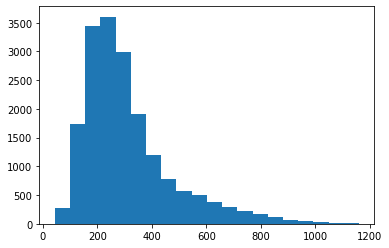

In [11]:
lyrics_len = np.array([len(lyr.split()) for lyr in lyrics_cleaner["lyrics"]])
plt.hist(lyrics_len, bins=20);

In [12]:
# let's check longest and shortest
print("SHORTEST : ", lyrics_cleaner["lyrics"][np.argmin(lyrics_len)])    # need to remove Spanish later on
print("\nLONGEST : ", lyrics_cleaner["lyrics"][np.argmax(lyrics_len)])

SHORTEST :  Corazon--mi corazon. Corazon--mi corazon. Yo te quiero--mi corazon. Corazon--mi corazon. Yo te quiero--mi corazon. Corazon--mi corazon. Yo te quiero--mi corazon. Espero que tu me quieras tambien. Corazon. Corazon--mi Corazon. Corazon--mi Corazon. Ayudame--mi Corazon. Yo te quiero--mi Corazon. Ayudame, te quiero, te quiero. Corazon

LONGEST :  Shimmy shimmy cocoa-pop. Shimmy shimmy cocoa-pop. Shimmy shimmy cocoa-pop. Shimmy shimmy cocoa-pop. We-we chocolate cross-over. Yea, we chocolate cross-over. See me cocoa might go pop. I'm cocoa and I might go pop. Now it's about time that I cleared this. So pardon me miss. But I'd like for you to hear this. If you kiss me then I'll kiss you back. You see, I feel real good inside, and it's just from your nearness. There's no need for you to fear this. Kiss me, I'll kiss you back. Mmmm-. Well ya look kinda cute to me. I think we can achieve this. Plus you act like you need this. Kiss me and I'll kiss you back. You act real fly. Money-B'

# add interesting song metadata

In [13]:
df_concat = lyrics_cleaner.copy()
df_concat["explicit"] = df_songs_meta["explicit"].astype(int)
df_concat["artists_dict"] = df_songs_meta["artists"]
df_concat["song_name"] = df_songs_meta["song_name"]
df_concat["song_popularity"] = df_songs_meta["popularity"]
df_concat["release_date"] = df_tracks_meta["release_date"]

acoustic_features = ["mode", "acousticness", "danceability", "energy", "instrumentalness", "liveness", "loudness", "speechiness", "valence", "tempo"]
for af in acoustic_features:
    df_concat[af] = df_acoustic_features[af]

print(df_concat.shape)
df_concat.head(10)

(18353, 16)


,lyrics,explicit,artists_dict,song_name,song_popularity,release_date,mode,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo
song_id,,,,,,,,,,,,,,,,
3e9HZxeyfWwjeyPAMmWSSQ,Thought I'd end up with Sean. But he wasn't a ...,1,{'66CXWjxzNUsdJxJ2JdwvnR': 'Ariana Grande'},"thank u, next",86,2019-02-08,1,0.22900,0.717,0.653,0.000000,0.1010,-5.634,0.0658,0.412,106.966
5p7ujcrUXASCNwRaWNHR1C,Found you when your heart was broke. I filled ...,1,{'26VFTg2z8YR0cCuwLzESi2': 'Halsey'},Without Me,87,2018-10-04,1,0.29700,0.752,0.488,0.000009,0.0936,-7.050,0.0705,0.533,136.041
2xLMifQCjDGFmkHkpNLD9h,"Astro, yeah. Sun is down, freezin' cold. That'...",1,{'0Y5tJX1MQlPlqiwlOH1tJY': 'Travis Scott'},SICKO MODE,85,2018-08-03,1,0.00513,0.834,0.730,0.000000,0.1240,-3.714,0.2220,0.446,155.008
1rqqCSm0Qe4I9rUvWncaom,"High, high hopes. Had to have high, high hopes...",0,{'20JZFwl6HVl6yg8a4H3ZqK': 'Panic! At The Disco'},High Hopes,86,2018-06-22,1,0.19300,0.579,0.904,0.000000,0.0640,-2.729,0.0618,0.681,82.014
0bYg9bo50gSsH3LtXe2SQn,I-I-I don't want a lot for Christmas. There is...,0,{'4iHNK0tOyZPYnBU7nGAgpQ': 'Mariah Carey'},All I Want for Christmas Is You,63,1994-11-01,1,0.16400,0.335,0.625,0.000000,0.0708,-7.462,0.0386,0.346,150.277
5hslUAKq9I9CG2bAulFkHN,It's the most wonderful time of the year. With...,0,{'4sj6D0zlMOl25nprDJBiU9': 'Andy Williams'},It's the Most Wonderful Time of the Year,52,1963,1,0.76600,0.240,0.598,0.000000,0.1170,-8.435,0.0370,0.776,202.082
2EjXfH91m7f8HiJN1yQg97,Rockin' around the Christmas Tree. At the Chri...,0,{'4cPHsZM98sKzmV26wlwD2W': 'Brenda Lee'},Rockin' Around The Christmas Tree,53,1964-10-19,1,0.61400,0.589,0.472,0.000000,0.5050,-8.749,0.0502,0.898,67.196
0MMSmg7zyo6pOKZrfHUOqu,"Have a holly, jolly Christmas;. It's the best ...",0,{'0MHgLfmQdutffmvWe5XBTN': 'Burl Ives'},A Holly Jolly Christmas,3,2015-10-28,1,0.68500,0.665,0.398,0.000000,0.1720,-11.886,0.0300,0.864,140.456
6Z924AupOiJLdnAKH6UgCu,"Jingle bell, jingle bell, jingle bell rock. Ji...",0,{'38EmEgXkgK51MT2tPY0EoC': 'Bobby Helms'},Jingle Bell Rock,51,1983-01-01,1,0.65100,0.757,0.428,0.000000,0.0644,-8.537,0.0360,0.816,119.813


In [14]:
# clean song title
def get_title(n):
    return n.split(" - ")[0]


song_names_full = df_concat["song_name"]
# print(song_names_full)
song_names = [get_title(n) for n in song_names_full]
# print(song_names)
df_concat["song_name"] = song_names

# extract just year / decade

In [15]:
def get_year(date):
    return int(date[:4])


release_dates = df_concat["release_date"]
# print(release_dates)
years = [get_year(date) for date in release_dates]
# print(years)

df_concat["release_year"] = years
df_concat = df_concat.drop(columns=["release_date"])
df_concat.head()

,lyrics,explicit,artists_dict,song_name,song_popularity,mode,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,release_year
song_id,,,,,,,,,,,,,,,,
3e9HZxeyfWwjeyPAMmWSSQ,Thought I'd end up with Sean. But he wasn't a ...,1,{'66CXWjxzNUsdJxJ2JdwvnR': 'Ariana Grande'},"thank u, next",86,1,0.22900,0.717,0.653,0.000000,0.1010,-5.634,0.0658,0.412,106.966,2019
5p7ujcrUXASCNwRaWNHR1C,Found you when your heart was broke. I filled ...,1,{'26VFTg2z8YR0cCuwLzESi2': 'Halsey'},Without Me,87,1,0.29700,0.752,0.488,0.000009,0.0936,-7.050,0.0705,0.533,136.041,2018
2xLMifQCjDGFmkHkpNLD9h,"Astro, yeah. Sun is down, freezin' cold. That'...",1,{'0Y5tJX1MQlPlqiwlOH1tJY': 'Travis Scott'},SICKO MODE,85,1,0.00513,0.834,0.730,0.000000,0.1240,-3.714,0.2220,0.446,155.008,2018
1rqqCSm0Qe4I9rUvWncaom,"High, high hopes. Had to have high, high hopes...",0,{'20JZFwl6HVl6yg8a4H3ZqK': 'Panic! At The Disco'},High Hopes,86,1,0.19300,0.579,0.904,0.000000,0.0640,-2.729,0.0618,0.681,82.014,2018
0bYg9bo50gSsH3LtXe2SQn,I-I-I don't want a lot for Christmas. There is...,0,{'4iHNK0tOyZPYnBU7nGAgpQ': 'Mariah Carey'},All I Want for Christmas Is You,63,1,0.16400,0.335,0.625,0.000000,0.0708,-7.462,0.0386,0.346,150.277,1994


# add artist metadata

In [16]:
try:
    df_artists_meta = df_artists_meta.set_index('artist_id')
except:
    # already done
    pass

In [17]:
df_artists_meta.head(10)
# do histogram of all genres, and take the one most popular

,name,followers,popularity,artist_type,main_genre,genres,image_url
artist_id,,,,,,,
66CXWjxzNUsdJxJ2JdwvnR,Ariana Grande,34554242,96,singer,dance pop,"['dance pop', 'pop', 'post-teen pop']",https://i.scdn.co/image/b1dfbe843b0b9f54ab2e58...
26VFTg2z8YR0cCuwLzESi2,Halsey,7368242,90,singer,dance pop,"['dance pop', 'electropop', 'etherpop', 'indie...",https://i.scdn.co/image/22a5f3d8c42bc7cb55215e...
0Y5tJX1MQlPlqiwlOH1tJY,Travis Scott,6313709,94,rapper,pop,"['pop', 'pop rap', 'rap']",https://i.scdn.co/image/dc5eba5e032c2e5bc4d42c...
246dkjvS1zLTtiykXe5h60,Post Malone,16737002,96,rapper,dfw rap,"['dfw rap', 'pop', 'rap']",https://i.scdn.co/image/f9d8b742b66609f12da023...
1zNqQNIdeOUZHb8zbZRFMX,Swae Lee,483032,89,singer,trap music,['trap music'],https://i.scdn.co/image/a177469870b41f7e17e3b5...
64KEffDW9EtZ1y2vBYgq8T,Marshmello,15566666,91,DJ,brostep,"['brostep', 'progressive electro house']",https://i.scdn.co/image/65f40b9a99ebb96921d536...
7EQ0qTo7fWT7DPxmxtSYEc,Bastille,3776115,85,band,metropopolis,"['metropopolis', 'modern rock', 'pop', 'tropic...",https://i.scdn.co/image/7fd538c4aa21542d840e17...
20JZFwl6HVl6yg8a4H3ZqK,Panic! At The Disco,7749228,88,band,baroque pop,"['baroque pop', 'emo', 'modern rock', 'pop punk']",https://i.scdn.co/image/58518a04cdd1f20a24cf05...
4iHNK0tOyZPYnBU7nGAgpQ,Mariah Carey,4682308,81,singer,dance pop,"['dance pop', 'pop', 'r&b', 'urban contemporary']",https://i.scdn.co/image/b9e312cf57cca3fab33e3d...


In [18]:
def get_artists(artist_dict, i=0):
    artist_dict = ast.literal_eval(artist_dict)
    artists = list(artist_dict.values())
    if "Unknown" in artists:
        artists.remove("Unknown")
    return artists

def get_genres(artist_dict, i=0):
    artist_dict = ast.literal_eval(artist_dict)
    artist_keys = list(artist_dict.keys())
    genres = []
    for artist in artist_keys:
        try:
            genres += ast.literal_eval(df_artists_meta.loc[artist]["genres"])
        except:
            # not in artist metadata
            continue
    if len(genres) == 0:
        genres = np.nan
    return genres

def get_main_genre(artist_dict, i=0):
    artist_dict = ast.literal_eval(artist_dict)
    artist_keys = list(artist_dict.keys())
    main_genre = []
    for artist in artist_keys:
        try:
            artist_main_genre = df_artists_meta.loc[artist]["main_genre"]
            if artist_main_genre != "-":
                main_genre.append(artist_main_genre)
        except:
            # not in artist metadata
            continue
    if len(main_genre) == 0:
        main_genre = np.nan
    return main_genre


artist_dicts = df_concat["artists_dict"]
artists = [get_artists(artist_dict, i) for i, artist_dict in enumerate(artist_dicts)]
genres = [get_genres(artist_dict, i) for i, artist_dict in enumerate(artist_dicts)]
h = np.sum([1 if g is np.nan else 0  for g in genres])
print(f"number of songs with no genre : {h}")
main_genre = [get_main_genre(artist_dict, i) for i, artist_dict in enumerate(artist_dicts)]
h = np.sum([1 if g is np.nan else 0  for g in main_genre])
print(f"number of songs with no main genre : {h}")

# add columns to main dataframe
df_concat["artists"] = artists
df_concat["genres"] = genres
df_concat["main_genre"] = main_genre
df_concat.head()

number of songs with no genre : 1468
number of songs with no main genre : 1468


,lyrics,explicit,artists_dict,song_name,song_popularity,mode,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,release_year,artists,genres,main_genre
song_id,,,,,,,,,,,,,,,,,,,
3e9HZxeyfWwjeyPAMmWSSQ,Thought I'd end up with Sean. But he wasn't a ...,1,{'66CXWjxzNUsdJxJ2JdwvnR': 'Ariana Grande'},"thank u, next",86,1,0.22900,0.717,0.653,0.000000,0.1010,-5.634,0.0658,0.412,106.966,2019,[Ariana Grande],"[dance pop, pop, post-teen pop]",[dance pop]
5p7ujcrUXASCNwRaWNHR1C,Found you when your heart was broke. I filled ...,1,{'26VFTg2z8YR0cCuwLzESi2': 'Halsey'},Without Me,87,1,0.29700,0.752,0.488,0.000009,0.0936,-7.050,0.0705,0.533,136.041,2018,[Halsey],"[dance pop, electropop, etherpop, indie poptim...",[dance pop]
2xLMifQCjDGFmkHkpNLD9h,"Astro, yeah. Sun is down, freezin' cold. That'...",1,{'0Y5tJX1MQlPlqiwlOH1tJY': 'Travis Scott'},SICKO MODE,85,1,0.00513,0.834,0.730,0.000000,0.1240,-3.714,0.2220,0.446,155.008,2018,[Travis Scott],"[pop, pop rap, rap]",[pop]
1rqqCSm0Qe4I9rUvWncaom,"High, high hopes. Had to have high, high hopes...",0,{'20JZFwl6HVl6yg8a4H3ZqK': 'Panic! At The Disco'},High Hopes,86,1,0.19300,0.579,0.904,0.000000,0.0640,-2.729,0.0618,0.681,82.014,2018,[Panic! At The Disco],"[baroque pop, emo, modern rock, pop punk]",[baroque pop]
0bYg9bo50gSsH3LtXe2SQn,I-I-I don't want a lot for Christmas. There is...,0,{'4iHNK0tOyZPYnBU7nGAgpQ': 'Mariah Carey'},All I Want for Christmas Is You,63,1,0.16400,0.335,0.625,0.000000,0.0708,-7.462,0.0386,0.346,150.277,1994,[Mariah Carey],"[dance pop, pop, r&b, urban contemporary]",[dance pop]


In [19]:
print(f"before : {len(df_concat)}")
df_concat = df_concat.dropna()
print(f"after : {len(df_concat)}")

before : 18353
after : 16885


# clean up genres

In [20]:
main_genre = df_concat["main_genre"]
main_genre = [g[0] for g in main_genre]
main_genre = pd.Series(main_genre)
print(main_genre.value_counts())

album rock              2146
dance pop               1628
adult standards         1562
contemporary country    1160
classic soul             815
                        ... 
instrumental funk          1
alabama indie              1
metalcore                  1
8-bit                      1
steelpan                   1
Length: 461, dtype: int64


In [21]:
# can group sub-genres
idx = ["soul" in g for g in main_genre]
main_genre.loc[idx].value_counts()

classic soul          815
chicago soul          124
british soul           60
northern soul          47
neo soul               37
southern soul           7
philly soul             5
memphis soul            5
soul                    4
soul jazz               3
deep northern soul      2
deep southern soul      2
neo soul-jazz           1
trap soul               1
dtype: int64

In [22]:
# df_less_genre.loc[df_less_genre["main_genre"] == genre_mapping["classic rock"]].head(50)

# # todo : genres, main_genre, artists
# feat = ["genres", "main_genre", "artists"]
# for f in feat:
#     print(f"\n{f}")
#     print("-------------")
#     vals = []
#     for g in df_concat[f].values:
#         vals += g
#     n_vals = len(vals)
#     print(f"number of vals : {n_vals}")
#     n_diff_vals = len(list(set(list(vals))))
#     print(f"number of different vals : {n_diff_vals}")

# min_songs = 100

# main_genre = df_concat["main_genre"].values
# vals = []
# for g in main_genre:
#     vals += g
# h = pd.Series(vals).value_counts()
# mask = (h >= min_songs).values
# n_genres = np.sum(mask)
# print(f"{n_genres} genres with at least {min_songs} songs\n")
# print(h[:n_genres])

# unique_main_genres = list(set(list(vals)))
# sub_genres = [val for val in unique_main_genres if "rock" in val]
# print(sub_genres)

In [23]:
# https://www.musicianwave.com/top-music-genres/
genres = ["dance/electronic", "adult standards", "hip-hop/rap", "religious", "boy band", "r&b", "pop rap", "soft rock",
          "rock", "pop", "acoustic/folk", "soul/motown", "country", "jazz/blues/funk", "pop rock", "classic rock",
          "indie/alternative", "reggae", "christmas", "latin", "christian", "movie", "disco", "hard rock/metal"]
genre_mapping = {}
for i, g in enumerate(genres):
    genre_mapping[g] = i


df_less_genre = df_concat.copy()


# pop rap
mask = np.logical_and(
    ["pop" in str(g) for g in df_less_genre['genres']],
    ["rap" in str(g) for g in df_less_genre['genres']]
)
# mask = ["pop rap" in str(g) for g in df_less_genre['genres']]
print("pop rap", sum(mask))
df_less_genre.loc[mask, "main_genre"] = genre_mapping["pop rap"]
# df_less_genre.loc[mask, "genres"] = genre_mapping["pop rap"]

# christmas
mask = np.logical_or(np.logical_or(np.logical_or(np.logical_or(
df_less_genre['song_name'].str.contains("christmas", case=False),
df_less_genre['song_name'].str.contains("santa ", case=False)), 
df_less_genre['song_name'].str.contains("let it snow", case=False)), 
df_less_genre['song_name'].str.contains("rudolph", case=False)),
df_less_genre['song_name'].str.contains("xmas", case=False))
print("christmas", sum(mask))
df_less_genre.loc[mask, "main_genre"] = genre_mapping["christmas"]
df_less_genre.loc[mask, "genres"] = genre_mapping["christmas"]


# christian
mask = np.logical_or(np.logical_or(
    ["worship" in str(g) for g in df_less_genre['genres']],
    ["christian" in str(g) for g in df_less_genre['genres']]
), ["gospel" in str(g) for g in df_less_genre['genres']])
print("religious", sum(mask))
df_less_genre.loc[mask, "main_genre"] = genre_mapping["religious"]
# df_less_genre.loc[mask, "genres"] = genre_mapping["religious"]

# latin music
mask = np.logical_or(np.logical_or(np.logical_or(np.logical_or(
    ["latin" in str(g) for g in df_less_genre['genres']],
    ["reggaeton" in str(g) for g in df_less_genre['genres']]
), ["bossa nova" in str(g) for g in df_less_genre['genres']]
), ["bachata" in str(g) for g in df_less_genre['genres']]
), ["salsa" in str(g) for g in df_less_genre['genres']])
print("latin", sum(mask))
df_less_genre.loc[mask, "main_genre"] = genre_mapping["latin"]
df_less_genre.loc[mask, "genres"] = genre_mapping["latin"]


mask = np.logical_or(
    ["reggae" in str(g) for g in df_less_genre['genres']],
    ["dancehall" in str(g) for g in df_less_genre['genres']]
)
print("reggae", sum(mask))
df_less_genre.loc[mask, "main_genre"] = genre_mapping["reggae"]
# df_less_genre.loc[mask, "genres"] = genre_mapping["reggae"]


# mask = ["boy band" in str(g) for g in df_less_genre['genres']]
# print("boy band", sum(mask))
# df_less_genre.loc[mask, "main_genre"] = genre_mapping["boy band"]

mask = ["disco" in str(g) for g in df_less_genre['main_genre']]
print("disco", sum(mask))
df_less_genre.loc[mask, "main_genre"] = genre_mapping["disco"]
# df_less_genre.loc[mask, "genres"] = genre_mapping["disco"]

mask = np.logical_or(np.logical_or(np.logical_or(
    ["hollywood" in str(g) for g in df_less_genre['main_genre']],
    ["movie" in str(g) for g in df_less_genre['main_genre']]
), ["soundtrack" in str(g) for g in df_less_genre['main_genre']]), 
["disney" in str(g) for g in df_less_genre['main_genre']])
print("movie", sum(mask))
df_less_genre.loc[mask, "main_genre"] = genre_mapping["movie"]
# df_less_genre.loc[mask, "genres"] = genre_mapping["movie"]


# electronic
mask = np.logical_or(np.logical_or(np.logical_or(np.logical_or(np.logical_or(
    ["techno" in str(g) for g in df_less_genre['main_genre']],
    ["house" in str(g) for g in df_less_genre['main_genre']]
), ["edm" in str(g) for g in df_less_genre['main_genre']]), 
["electronic" in str(g) for g in df_less_genre['main_genre']]), 
["step" in str(g) for g in df_less_genre['main_genre']]),
["dance" in str(g) for g in df_less_genre['main_genre']])   # include dance pop
print("dance/electronic", sum(mask))
df_less_genre.loc[mask, "main_genre"] = genre_mapping["dance/electronic"]
# df_less_genre.loc[mask, "genres"] = genre_mapping["dance/electronic"]


# mask = np.array(["dance pop" in str(g) for g in df_less_genre['main_genre']])
# print("dance pop", sum(mask))
# df_less_genre.loc[mask, "main_genre"] = genre_mapping["dance pop"]

# mask = ["soft rock" in str(g) for g in df_less_genre['genres']]
# print("soft rock", sum(mask))
# df_less_genre.loc[mask, "main_genre"] = genre_mapping["soft rock"]
# df_less_genre.loc[mask, "genres"] = genre_mapping["soft rock"]


mask = np.logical_or(np.logical_or(np.logical_or(
    ["brill building pop" in str(g) for g in df_less_genre['main_genre']],
    ["easy" in str(g) for g in df_less_genre['main_genre']]
), ["adult" in str(g) for g in df_less_genre['main_genre']]
), ["british invasion" in str(g) for g in df_less_genre['main_genre']]
)
print("adult standards", sum(mask))
df_less_genre.loc[mask, "main_genre"] = genre_mapping["adult standards"]
# df_less_genre.loc[mask, "genres"] = genre_mapping["adult standards"]


mask = np.logical_or(np.logical_or(np.logical_or(
    ["rap" in str(g) for g in df_less_genre['main_genre']],
    ["hop" in str(g) for g in df_less_genre['main_genre']]
), ["g funk" in str(g) for g in df_less_genre['main_genre']]
), ["freestyle" in str(g) for g in df_less_genre['main_genre']])
print("hip-hop", sum(mask))
df_less_genre.loc[mask, "main_genre"] = genre_mapping["hip-hop/rap"]
# df_less_genre.loc[mask, "genres"] = genre_mapping["hip-hop/rap"]


# acoustic
mask = np.logical_or(
    ["acoustic" in str(g) for g in df_less_genre['main_genre']],
    ["folk" in str(g) for g in df_less_genre['main_genre']]
)
print("acoustic/folk", sum(mask))
df_less_genre.loc[mask, "main_genre"] = genre_mapping["acoustic/folk"]
# df_less_genre.loc[mask, "genres"] = genre_mapping["acoustic/folk"]


# soul
mask = np.logical_or(
    ["soul" in str(g) for g in df_less_genre['main_genre']],
    ["motown" in str(g) for g in df_less_genre['main_genre']]
)   
print("soul/motown", sum(mask))
df_less_genre.loc[mask, "main_genre"] = genre_mapping["soul/motown"]
# df_less_genre.loc[mask, "genres"] = genre_mapping["soul/motown"]


# soul
mask = np.logical_or(np.logical_or(
    ["new jack swing" in str(g) for g in df_less_genre['main_genre']],
    ["girl group" in str(g) for g in df_less_genre['main_genre']]
), ["r&b" in str(g) for g in df_less_genre['main_genre']])     
print("r&b", sum(mask))
df_less_genre.loc[mask, "main_genre"] = genre_mapping["r&b"]
# df_less_genre.loc[mask, "genres"] = genre_mapping["r&b"]

# country music
mask = np.logical_or(np.logical_or(
    ["country" in str(g) for g in df_less_genre['main_genre']],
    ["southern" in str(g) for g in df_less_genre['main_genre']]
), ["bluegrass" in str(g) for g in df_less_genre['main_genre']])
print("country", sum(mask))
df_less_genre.loc[mask, "main_genre"] = genre_mapping["country"]
# df_less_genre.loc[mask, "genres"] = genre_mapping["country"]

# jazz
mask = np.logical_or(np.logical_or(
    ["jazz" in str(g) for g in df_less_genre['main_genre']],
    ["blues" in str(g) for g in df_less_genre['main_genre']]
), ["funk" in str(g) for g in df_less_genre['main_genre']])
print("jazz/blues/funk", sum(mask))
df_less_genre.loc[mask, "main_genre"] = genre_mapping["jazz/blues/funk"]
# df_less_genre.loc[mask, "genres"] = genre_mapping["jazz/blues/funk"]

# indie
mask = np.logical_or(np.logical_or(
    ["indie" in str(g) for g in df_less_genre['main_genre']],
    ["alternative" in str(g) for g in df_less_genre['main_genre']]
), ["punk" in str(g) for g in df_less_genre['main_genre']])
print("indie/alternative", sum(mask))
df_less_genre.loc[mask, "main_genre"] = genre_mapping["indie/alternative"]
# df_less_genre.loc[mask, "genres"] = genre_mapping["indie/alternative"]


mask = np.logical_or(
    ["hard rock" in str(g) for g in df_less_genre['genres']],
    ["metal" in str(g) for g in df_less_genre['genres']]
)
print("hard rock/metal", sum(mask))
df_less_genre.loc[mask, "main_genre"] = genre_mapping["hard rock/metal"]
df_less_genre.loc[mask, "genres"] = genre_mapping["hard rock/metal"]

mask = ["classic rock" in str(g) for g in df_less_genre['genres']]
print("classic rock", sum(mask))
df_less_genre.loc[mask, "main_genre"] = genre_mapping["classic rock"]
# df_less_genre.loc[mask, "genres"] = genre_mapping["classic rock"]


mask = np.logical_or(np.logical_or(np.logical_or(np.logical_or(
    ["pop rock" in str(g) for g in df_less_genre['main_genre']],
    ["permanent wave" in str(g) for g in df_less_genre['main_genre']]
), ["soft rock" in str(g) for g in df_less_genre['main_genre']]
), ["neo mellow" in str(g) for g in df_less_genre['main_genre']]
), ["pop rock" in str(g) for g in df_less_genre['genres']]
)
# print("pop rock", sum(mask))
# df_less_genre.loc[mask, "main_genre"] = genre_mapping["pop rock"]
# df_less_genre.loc[mask, "genres"] = genre_mapping["pop rock"]
mask = np.logical_or(np.logical_or(
    ["pop" in str(g) for g in df_less_genre['main_genre']],
    ["boy band" in str(g) for g in df_less_genre['genres']]
), mask)
print("pop", sum(mask))
df_less_genre.loc[mask, "main_genre"] = genre_mapping["pop"]
# df_less_genre.loc[mask, "genres"] = genre_mapping["pop"]


# album rock
mask = np.logical_or(
    ["rock" in str(g) for g in df_less_genre['main_genre']],
    ["metal" in str(g) for g in df_less_genre['main_genre']]
)
print("rock", sum(mask))
df_less_genre.loc[mask, "main_genre"] = genre_mapping["rock"]
# df_less_genre.loc[mask, "genres"] = genre_mapping["rock"]

# mask = np.array(
#     ["pop" in str(g) for g in df_less_genre['main_genre']],
# )



# gen = "beach music"
# mask = [gen in str(g) for g in df_less_genre['main_genre']]
# print(gen, sum(mask))
# df_less_genre.loc[mask, "main_genre"] = gen



df_less_genre.head(20)

pop rap 1756
christmas 31
religious 374
latin 169
reggae 92
disco 457
movie 110
dance/electronic 1549
adult standards 2412
hip-hop 494
acoustic/folk 319
soul/motown 1215
r&b 153
country 1357
jazz/blues/funk 496
indie/alternative 553
hard rock/metal 1498
classic rock 1218
pop 2369
rock 795


,lyrics,explicit,artists_dict,song_name,song_popularity,mode,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,release_year,artists,genres,main_genre
song_id,,,,,,,,,,,,,,,,,,,
3e9HZxeyfWwjeyPAMmWSSQ,Thought I'd end up with Sean. But he wasn't a ...,1,{'66CXWjxzNUsdJxJ2JdwvnR': 'Ariana Grande'},"thank u, next",86,1,0.22900,0.717,0.653,0.000000,0.1010,-5.634,0.0658,0.412,106.966,2019,[Ariana Grande],"[dance pop, pop, post-teen pop]",0
5p7ujcrUXASCNwRaWNHR1C,Found you when your heart was broke. I filled ...,1,{'26VFTg2z8YR0cCuwLzESi2': 'Halsey'},Without Me,87,1,0.29700,0.752,0.488,0.000009,0.0936,-7.050,0.0705,0.533,136.041,2018,[Halsey],"[dance pop, electropop, etherpop, indie poptim...",0
2xLMifQCjDGFmkHkpNLD9h,"Astro, yeah. Sun is down, freezin' cold. That'...",1,{'0Y5tJX1MQlPlqiwlOH1tJY': 'Travis Scott'},SICKO MODE,85,1,0.00513,0.834,0.730,0.000000,0.1240,-3.714,0.2220,0.446,155.008,2018,[Travis Scott],"[pop, pop rap, rap]",6
1rqqCSm0Qe4I9rUvWncaom,"High, high hopes. Had to have high, high hopes...",0,{'20JZFwl6HVl6yg8a4H3ZqK': 'Panic! At The Disco'},High Hopes,86,1,0.19300,0.579,0.904,0.000000,0.0640,-2.729,0.0618,0.681,82.014,2018,[Panic! At The Disco],"[baroque pop, emo, modern rock, pop punk]",9
0bYg9bo50gSsH3LtXe2SQn,I-I-I don't want a lot for Christmas. There is...,0,{'4iHNK0tOyZPYnBU7nGAgpQ': 'Mariah Carey'},All I Want for Christmas Is You,63,1,0.16400,0.335,0.625,0.000000,0.0708,-7.462,0.0386,0.346,150.277,1994,[Mariah Carey],18,18
5hslUAKq9I9CG2bAulFkHN,It's the most wonderful time of the year. With...,0,{'4sj6D0zlMOl25nprDJBiU9': 'Andy Williams'},It's the Most Wonderful Time of the Year,52,1,0.76600,0.240,0.598,0.000000,0.1170,-8.435,0.0370,0.776,202.082,1963,[Andy Williams],"[adult standards, brill building pop, easy lis...",1
2EjXfH91m7f8HiJN1yQg97,Rockin' around the Christmas Tree. At the Chri...,0,{'4cPHsZM98sKzmV26wlwD2W': 'Brenda Lee'},Rockin' Around The Christmas Tree,53,1,0.61400,0.589,0.472,0.000000,0.5050,-8.749,0.0502,0.898,67.196,1964,[Brenda Lee],18,18
0MMSmg7zyo6pOKZrfHUOqu,"Have a holly, jolly Christmas;. It's the best ...",0,{'0MHgLfmQdutffmvWe5XBTN': 'Burl Ives'},A Holly Jolly Christmas,3,1,0.68500,0.665,0.398,0.000000,0.1720,-11.886,0.0300,0.864,140.456,2015,[Burl Ives],18,18
1xzBco0xcoJEDXktl7Jxrr,16yrold. Bitch!. Daytrip took it to 10. I got ...,1,{'2RDOrhPqAM4jzTRCEb19qX': 'Sheck Wes'},Mo Bamba,81,1,0.19400,0.729,0.625,0.009860,0.2480,-5.266,0.0315,0.261,146.034,2018,[Sheck Wes],"[rap, trap music, underground hip hop, vapor t...",2


In [24]:
min_songs = 5

main_genre = df_less_genre["main_genre"].values
vals = []
for g in main_genre:
    if isinstance(g, list):
        vals += g
    else:
        vals += [genres[g]]
h = pd.Series(vals).value_counts()
# print(h[::-1][:100])
mask = (h >= min_songs).values
n_genres = np.sum(mask)
print(f"{n_genres} genres with at least {min_songs} songs\n")
print(h[:n_genres])

47 genres with at least 5 songs

pop                           2369
adult standards               2209
pop rap                       1610
hard rock/metal               1498
dance/electronic              1417
country                       1295
soul/motown                   1212
classic rock                  1114
rock                           795
hip-hop/rap                    487
disco                          456
jazz/blues/funk                358
religious                      357
karaoke                        327
acoustic/folk                  199
latin                          169
r&b                            151
indie/alternative              141
movie                          110
reggae                          90
beach music                     55
mellow gold                     49
christmas                       31
emo                             28
fake                            24
electro                         20
minneapolis sound               16
quiet storm           

In [25]:
# remove obscure genres
mask = np.array(
    [isinstance(g, list) for g in df_less_genre['main_genre']],
)
print("unclassified songs", sum(mask))
df_less_genre.loc[mask, "main_genre"] = np.nan

unclassified songs 817


In [26]:
print(f"before : {len(df_less_genre)}")
df_clean = df_less_genre.dropna()
print(f"after : {len(df_clean)}")


def get_genre(n):
    return genres[n]

def get_artist(n):
    # just take first artist
    return n[0]

df_clean["genre"] = [get_genre(n) for n in df_clean["main_genre"]]
df_clean["artist"] = [get_artist(n) for n in df_clean["artists"]]


# df_clean = df_clean.drop(columns=['genres', 'main_genre', "artists_dict", "artists"])
df_clean = df_clean.drop(columns=['main_genre', "artists_dict", "artists", "genres"])


print(df_clean.shape)
df_clean.head()

before : 16885
after : 16068
(16068, 17)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,lyrics,explicit,song_name,song_popularity,mode,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,release_year,genre,artist
song_id,,,,,,,,,,,,,,,,,
3e9HZxeyfWwjeyPAMmWSSQ,Thought I'd end up with Sean. But he wasn't a ...,1,"thank u, next",86,1,0.22900,0.717,0.653,0.000000,0.1010,-5.634,0.0658,0.412,106.966,2019,dance/electronic,Ariana Grande
5p7ujcrUXASCNwRaWNHR1C,Found you when your heart was broke. I filled ...,1,Without Me,87,1,0.29700,0.752,0.488,0.000009,0.0936,-7.050,0.0705,0.533,136.041,2018,dance/electronic,Halsey
2xLMifQCjDGFmkHkpNLD9h,"Astro, yeah. Sun is down, freezin' cold. That'...",1,SICKO MODE,85,1,0.00513,0.834,0.730,0.000000,0.1240,-3.714,0.2220,0.446,155.008,2018,pop rap,Travis Scott
1rqqCSm0Qe4I9rUvWncaom,"High, high hopes. Had to have high, high hopes...",0,High Hopes,86,1,0.19300,0.579,0.904,0.000000,0.0640,-2.729,0.0618,0.681,82.014,2018,pop,Panic! At The Disco
0bYg9bo50gSsH3LtXe2SQn,I-I-I don't want a lot for Christmas. There is...,0,All I Want for Christmas Is You,63,1,0.16400,0.335,0.625,0.000000,0.0708,-7.462,0.0386,0.346,150.277,1994,christmas,Mariah Carey


# visualization

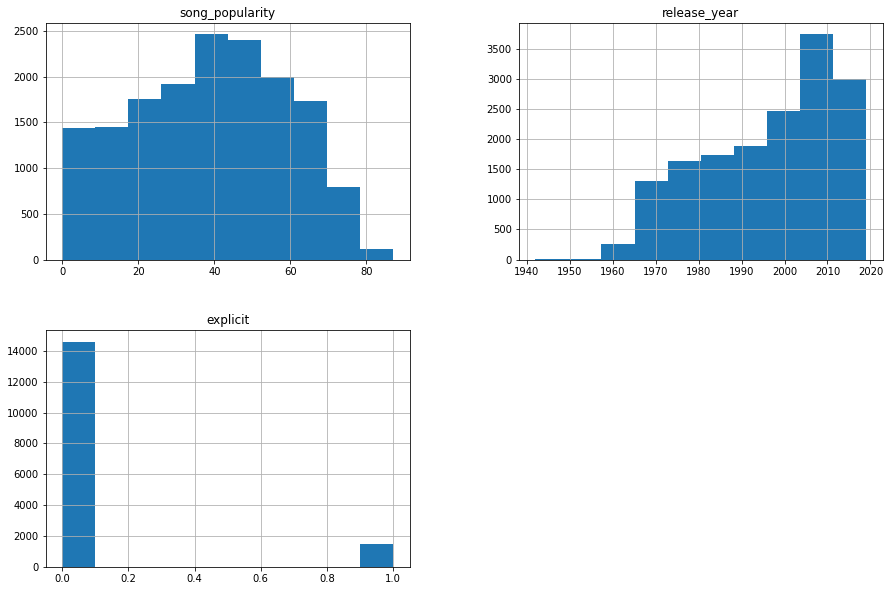

In [27]:
df_clean.hist(column=["song_popularity", "release_year", "explicit"], figsize=(15, 10));

In [28]:
print(len(df_clean["genre"].value_counts()))
df_clean["genre"].value_counts()

20


pop                  2369
adult standards      2209
pop rap              1610
hard rock/metal      1498
dance/electronic     1417
country              1295
soul/motown          1212
classic rock         1114
rock                  795
hip-hop/rap           487
disco                 456
jazz/blues/funk       358
religious             357
acoustic/folk         199
latin                 169
r&b                   151
indie/alternative     141
movie                 110
reggae                 90
christmas              31
Name: genre, dtype: int64

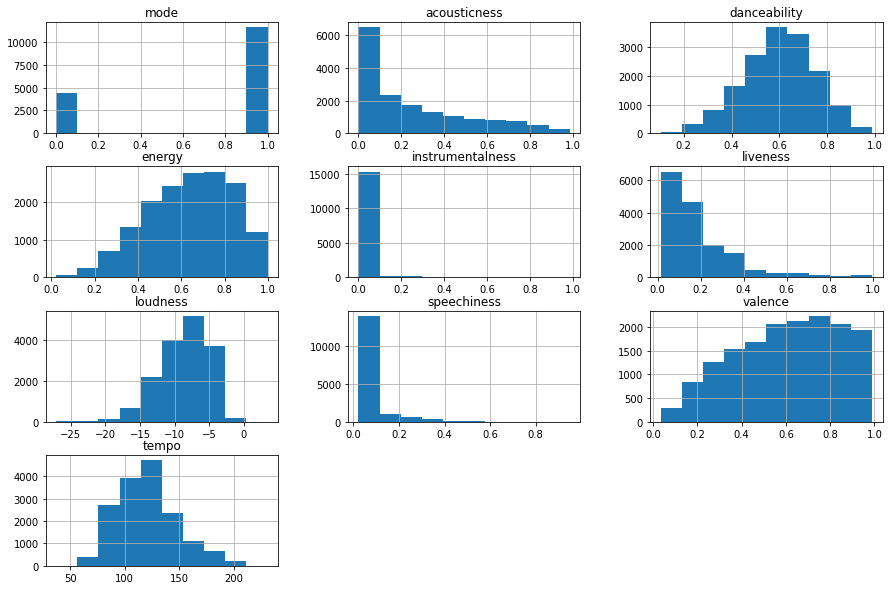

In [29]:
df_clean.hist(column=acoustic_features, figsize=(15, 10));

In [31]:
# SAVE TO PICKLE
df_clean.to_pickle('df_clean_v1_07122021_py35.pkl')